In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import rioxarray
import xarray as xr
import rasterio as rio
import glob
import datetime
import geopandas as gpd
from datetime import timedelta
from scipy.optimize import curve_fit

In [2]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds

def hyp3_to_xarray(hyp3_dir, file_type='corr_aoi', epsg=32645, interpolate_na=False):
    
    dirs = os.listdir(hyp3_dir) #list generated interferograms
    datasets = []
    
    for idir in dirs:
        tif_path = glob.glob(f'{hyp3_dir}/{idir}/*/*{file_type}.tif')[0]
        tif_fn = os.path.split(tif_path)[-1]
        dates = f'{tif_fn[14:22]}_{tif_fn[23:31]}' #parse filename for interferogram dates
        start_date = datetime.datetime.strptime(dates[:8], '%Y%m%d')
        end_date = datetime.datetime.strptime(dates[-8:], '%Y%m%d')
        t_baseline = end_date - start_date
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        src = src.assign_coords(start_date = ('dates', [start_date]))
        src = src.assign_coords(end_date = ('dates', [end_date]))
        src = src.assign_coords(t_baseline = ('dates', [t_baseline]))
        
        src = src.rename({'band1':file_type})
        src = src.rio.write_crs(epsg)
        # in future, should get spatial baseline, flight dir, and orbit from metadata
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)
        
        datasets.append(src)
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    return ds 

In [3]:
# open ints and dems
hyp3_dir = './data/data_igrams'
corr_ds = hyp3_to_xarray(hyp3_dir)

### Examine spatial coherence

In [19]:
corr_12_ds = corr_ds.where(corr_ds.t_baseline.dt.days <= 12, drop=True)

In [27]:
mean_corr = corr_12_ds.corr_aoi.mean(dim='dates')
median_corr = corr_12_ds.corr_aoi.median(dim='dates')

Text(0.5, 1.0, 'mean - median  12 day coherence')

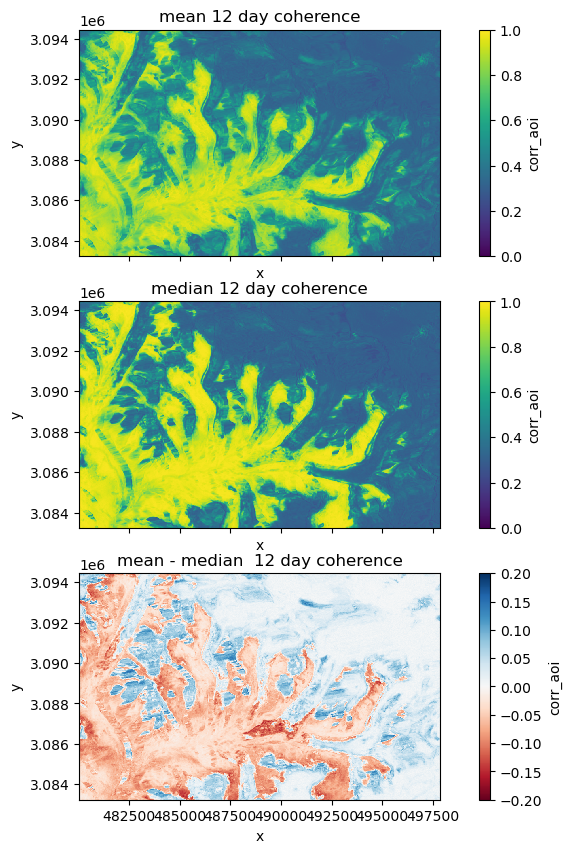

In [37]:
f, ax = plt.subplots(3, 1, figsize=(10, 10), sharey=True, sharex=True)
mean_corr.plot(ax=ax[0], vmin=0, vmax=1)
ax[0].set_aspect('equal')
ax[0].set_title('mean 12 day coherence')
median_corr.plot(ax=ax[1], vmin=0, vmax=1)
ax[1].set_aspect('equal')
ax[1].set_title('median 12 day coherence')
(mean_corr - median_corr).plot(ax=ax[2], vmin=-0.2, vmax=0.2, cmap='RdBu')
ax[2].set_aspect('equal')
ax[2].set_title('mean - median  12 day coherence')

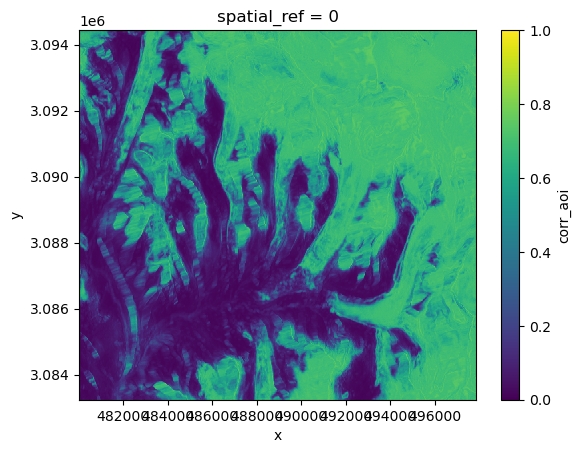

In [40]:
# examine potential weights
f, ax = plt.subplots()
(1-median_corr).plot(ax=ax, vmin=0, vmax=1)

In [41]:
(1 - median_corr).rio.to_raster('./data/weighting/inverse_median_coherence.tif')

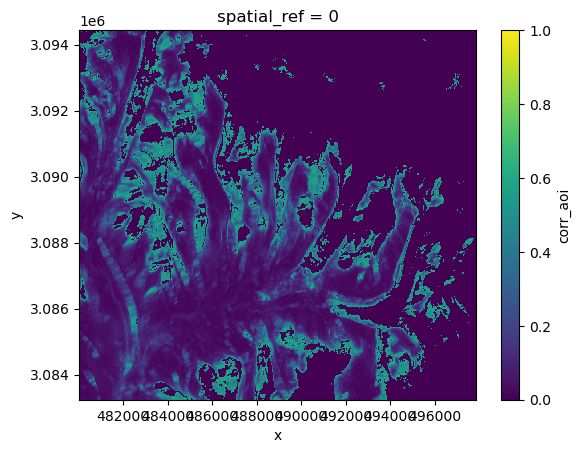

In [43]:
# examine potential weights
# where InSAR coherence high, weight by 1-InSAR coherence. 
# where InSAR coherence low, weight by SNR
f, ax = plt.subplots()
xr.where(1-median_corr < 0.6, 1 - median_corr, 0).plot(ax=ax, vmin=0, vmax=1)

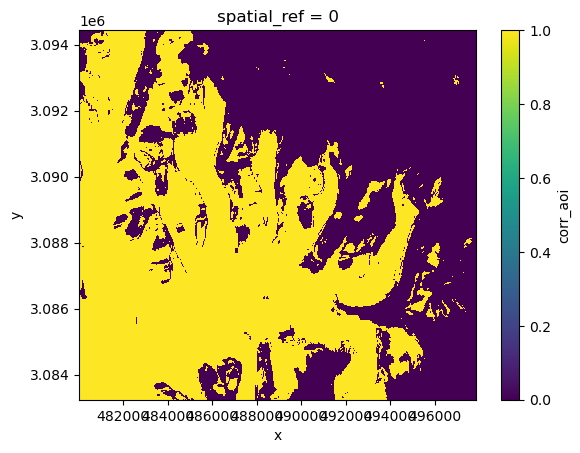

In [24]:
# examine potential masks
f, ax = plt.subplots()
xr.where(mean_corr >= 0.50, 1, 0).plot(ax=ax)

### Examine temporal coherence

In [4]:
def year_fraction(date):
    start = datetime.date(date.year.item(), 1, 1).toordinal()
    year_length = datetime.date(date.year.item()+1, 1, 1).toordinal() - start
    return date.year.item() + float(date.date.item().toordinal() - start) / year_length

In [5]:
# load json of aois
imja_fn = '/mnt/c/Users/qbren/Desktop/taco/projects/fusits/mapping/imja_moraine.shp'
imja_gdf = gpd.read_file(imja_fn)
imja_corr_ds = corr_ds.rio.clip(imja_gdf.geometry.values, crs=imja_gdf.crs, drop=True)
imja_corr_ds = imja_corr_ds.assign_coords(middle_date = ('dates', (imja_corr_ds.t_baseline/2+imja_corr_ds.start_date).data))

Text(0.5, 1.0, 'Imja Lake moraine dam coherence')

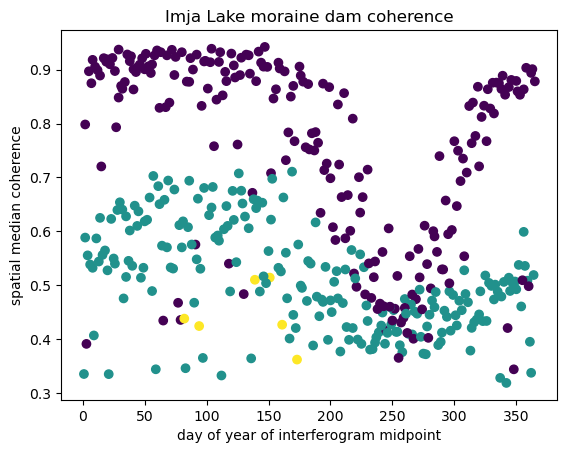

In [14]:
f, ax = plt.subplots()
ax.scatter(imja_corr_ds.middle_date.dt.dayofyear, imja_corr_ds.corr_aoi.median(dim=['x', 'y']), c=imja_corr_ds.t_baseline, label=imja_corr_ds.t_baseline)
ax.set_xlabel('day of year of interferogram midpoint')
ax.set_ylabel('spatial median coherence')
ax.set_title('Imja Lake moraine dam coherence')

In [17]:
imja_corr_low = imja_corr_ds.where(imja_corr_ds.middle_date.dt.dayofyear > 225, drop=True)

In [19]:
imja_corr_low = imja_corr_low.where(imja_corr_low.middle_date.dt.dayofyear < 275, drop=True)

In [29]:
set(imja_corr_low.start_date.dt.strftime('%Y%m%d').values)

{'20170803',
 '20170815',
 '20170827',
 '20170908',
 '20170920',
 '20180810',
 '20180822',
 '20180903',
 '20180915',
 '20190805',
 '20190817',
 '20190829',
 '20190910',
 '20190922',
 '20200811',
 '20200823',
 '20200904',
 '20200916',
 '20210806',
 '20210818',
 '20210830',
 '20210911',
 '20210923',
 '20220813',
 '20220825',
 '20220906',
 '20220918',
 '20230808',
 '20230820',
 '20230901',
 '20230913',
 '20230925'}

In [ ]:
# # load json of aois
# imja_fn = '/mnt/c/Users/qbren/Desktop/taco/projects/fusits/mapping/imja_moraine.shp'
# imja_gdf = gpd.read_file(imja_fn)
# imja_corr_ds = corr_ds.rio.clip(imja_gdf.geometry.values, crs=imja_gdf.crs, drop=True)

In [18]:
corr_12_ds = imja_corr_ds.where(imja_corr_ds.t_baseline.dt.days <= 12, drop=True)
corr_24_ds = imja_corr_ds.where(imja_corr_ds.t_baseline.dt.days == 24, drop=True)
corr_long_ds = imja_corr_ds.where(imja_corr_ds.t_baseline.dt.days > 24, drop=True)

NameError: name 'imja_corr_ds' is not defined

In [89]:
ds_list = [corr_12_ds, corr_24_ds, corr_long_ds]

In [90]:
corr_lines_all = []
for ds in ds_list:
    corr_lines = []
    for corr in ds.median(dim=('x', 'y')).corr_clipped:
        corr_lines.append([(year_fraction(corr.start_date.dt), corr.item()),
                          (year_fraction(corr.end_date.dt), corr.item())])
    corr_lines_all.append(corr_lines)

In [91]:
colors = ['r', 'b', 'g']

corr_lc_all = []
for i, corr_lines in enumerate(corr_lines_all):
    corr_lc = mc.LineCollection(corr_lines, linewidths=1.5, color=(colors[i]), alpha=0.5)
    corr_lc_all.append(corr_lc)

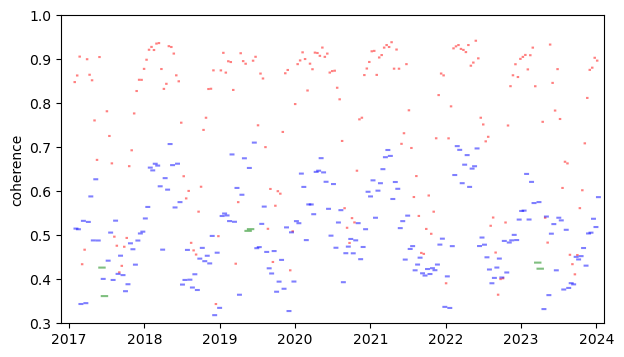

In [92]:
f, ax = plt.subplots(figsize=(7, 4))
for corr_lc in corr_lc_all: 
    ax.add_collection(corr_lc)
    corr_lc.set_snap(False)  
ax.set_xlim(2016.9, 2024.1)
ax.set_ylim(0.3, 1)
ax.set_ylabel('coherence')
f.savefig('imja_dam_coherence.png', dpi=300)

### Fitting functions to coherence

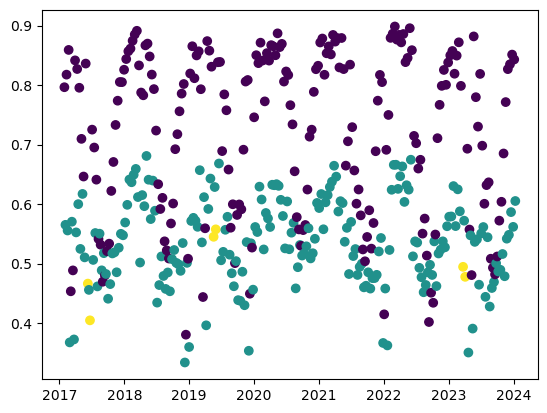

In [93]:
f, ax = plt.subplots()
ax.scatter(imja_corr_ds.middle_date, imja_corr_ds.corr_clipped.mean(dim=['x','y']), c=imja_corr_ds.t_baseline)

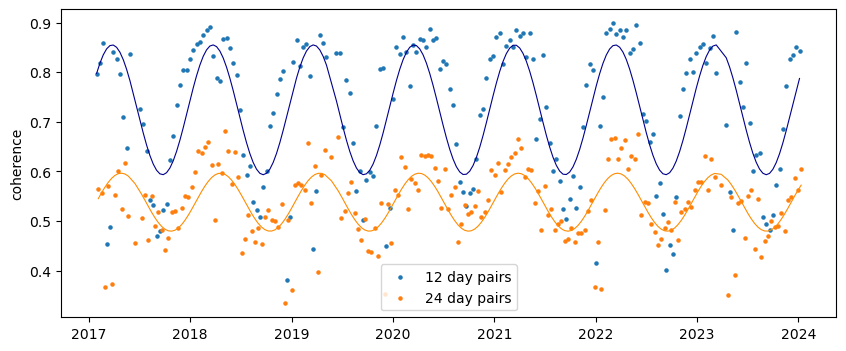

In [106]:
# Function to fit a sine wave
def sine_function(t, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * t + phase) + offset

# Initial guess for the parameters
initial_guess = (0.3, 1/3.154e+16, 0.0, 0.0)

# Perform curve fitting
params_12, covariance_12 = curve_fit(sine_function, corr_12_ds.middle_date.values.astype(np.int64), corr_12_ds.corr_clipped.mean(dim=['x','y']).values, p0=initial_guess)
# Perform curve fitting
params_24, covariance_24 = curve_fit(sine_function, corr_24_ds.middle_date.values.astype(np.int64), corr_24_ds.corr_clipped.mean(dim=['x','y']).values, p0=initial_guess)



# Extract the fitted parameters
amplitude_12, frequency_12, phase_12, offset_12 = params_12
amplitude_24, frequency_24, phase_24, offset_24 = params_24

# Generate the fitted sine wave
fitted_sine_wave_12 = sine_function(corr_12_ds.middle_date.values.astype(np.int64), amplitude_12, frequency_12, phase_12, offset_12)
fitted_sine_wave_24 = sine_function(corr_24_ds.middle_date.values.astype(np.int64), amplitude_24, frequency_24, phase_24, offset_24)

# Plot the original data and the fitted sine wave
f, ax = plt.subplots(figsize=(10, 4))
ax.scatter(corr_12_ds.middle_date, corr_12_ds.corr_clipped.mean(dim=['x','y']).values, label='12 day pairs', s=5)
ax.scatter(corr_24_ds.middle_date, corr_24_ds.corr_clipped.mean(dim=['x','y']).values, label='24 day pairs', s=5)
plt.plot(corr_12_ds.middle_date.values, fitted_sine_wave_12, c='darkblue', linewidth=0.8)
plt.plot(corr_24_ds.middle_date.values, fitted_sine_wave_24, c='darkorange', linewidth=0.8)
plt.ylabel('coherence')
plt.legend()
plt.show()

In [ ]:
imja_corr_ds.median(dim=['x', 'y']).idxmax()